# Asset Portfolio Management using Deep Reinforcement Learning
---

## Uniform Weights and Maximum Sharpe Strategies
---
We present two allocation strategies which will be used for comparision with the proposed Deep Reinforcement Learning (DRL) methodology.

The two strategies are:

1. Uniform Weights Strategy. This is a naive method where the weights of the assets are distributed equally among the assets in the portfolio.

2. Maximum Sharpe Strategy. This is an optimization strategy where the allocation is based on achieving the maximum possible risk based return (Sharpe Ratio). We will make use of the PyPotfolioOpt Library which is a library that implements portfolio optimisation methods.

### 4.1 Import Relevant Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from datetime import datetime

sns.set()

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 4.2 Load the Train and Test Data for Close Prices

In [3]:
%store -r prices_train
%store -r prices_test

In [4]:
prices_train_df = prices_train.copy()
prices_test_df = prices_test.copy()

In [5]:
prices_train_df = prices_train_df.reset_index(drop=True).set_index(['date'])
prices_test_df = prices_test_df.reset_index(drop=True).set_index(['date'])

In [6]:
prices_train_df.head()

,AAPL,MSFT,JPM,V,RTX,PG,GS,NKE,DIS,AXP,...,CVX,MCD,VZ,CSCO,XOM,BA,MMM,PFE,WBA,DD
date,,,,,,,,,,,,,,,,,,,,,
2008-12-31,2.629544,14.793870,23.197927,12.017439,25.218483,42.684620,70.854607,8.608677,19.538342,15.163033,...,46.442257,43.119572,17.798944,12.189656,52.298050,31.760571,41.426876,10.602845,18.526949,14.225616
2009-01-02,2.795913,15.471161,23.346874,12.244266,25.853655,43.361279,72.844467,8.956398,20.597496,15.800624,...,48.043262,44.201206,18.187479,12.683227,53.483833,33.680935,42.614807,10.938112,19.187819,14.527276
2009-01-05,2.913912,15.615757,21.782980,12.331331,25.547832,43.050556,74.540482,9.020543,20.235834,16.307413,...,48.131180,44.069469,17.053383,12.795406,53.477268,34.365715,42.118034,10.872255,20.156599,14.187901
2009-01-06,2.865849,15.798391,22.252140,13.199700,25.820715,42.926285,74.481720,8.838243,20.933319,17.222921,...,48.564404,43.084919,16.780365,13.303929,52.605965,34.469925,42.614807,10.656727,20.058964,15.130617
2009-01-07,2.803923,14.847140,20.919094,12.913300,25.180843,42.173668,70.946960,8.517526,19.960283,16.497395,...,46.435970,42.460896,16.993446,12.952450,51.263000,33.316200,41.808441,10.471133,20.299286,15.158899


In [7]:
prices_test_df.head()

,AAPL,MSFT,JPM,V,RTX,PG,GS,NKE,DIS,AXP,...,CVX,MCD,VZ,CSCO,XOM,BA,MMM,PFE,WBA,DD
date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,53.367214,105.498566,100.253922,138.087463,76.551064,82.865334,216.269882,72.523842,116.560318,103.342613,...,106.399857,158.584137,50.463459,42.286266,71.711418,344.585480,185.130997,38.811462,71.427933,76.540825
2018-10-22,53.693295,106.440323,98.813904,138.639496,75.194695,82.200897,211.162354,73.198166,115.942711,101.193077,...,105.562263,157.769867,50.536991,42.677971,70.994041,344.314697,186.529770,38.698093,71.704979,74.650284
2018-10-23,54.199440,104.954857,97.782646,137.141098,77.348228,82.732452,208.265518,71.683380,115.530975,101.067207,...,102.130898,167.730469,52.586784,42.360874,69.847992,338.578979,178.368668,38.462597,71.344826,72.799652
2018-10-24,52.340309,99.343018,95.961716,132.350235,72.618797,84.915611,199.327316,70.481323,109.413765,98.607803,...,99.257896,167.919830,52.779808,41.101799,67.905815,343.028229,170.948578,37.049690,68.519127,70.136909
2018-10-25,53.486454,105.149040,97.420326,138.521194,74.004913,84.478973,203.929825,71.439072,111.913597,100.311958,...,100.491753,165.988327,51.869820,42.407513,68.509460,351.849396,171.365448,37.860809,69.941200,70.456429


### 4.3 Uniform Weights Portfolio

In [8]:
# Define a Function for Displaying the Cleaned Weights
def show_clean_p(port_df):
    p1_show_1 = (port_df.transpose()[0]).map(lambda x: "{:.3%}".format(x)).to_frame().transpose()
    return display(HTML(p1_show_1.to_html()))

In [9]:
ticker_list = list(prices_train_df.columns) # Get List of all ticker symbols
n_assets = len(ticker_list) # Number of assets

uniform_weights = np.ones((n_assets))/n_assets

uniform_weights_port = pd.DataFrame([uniform_weights], columns = ticker_list)

print("\nuniform weights portfolio:\n")
show_clean_p(uniform_weights_port)


uniform weights portfolio:



,AAPL,MSFT,JPM,V,RTX,PG,GS,NKE,DIS,AXP,HD,INTC,WMT,IBM,MRK,UNH,KO,CAT,TRV,JNJ,CVX,MCD,VZ,CSCO,XOM,BA,MMM,PFE,WBA,DD
0,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%,3.333%


In [10]:
uniform_weights

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [11]:
# Plotting the Daily Draw Down

ticker_symb = ['AAPL']
prices = prices_train_df[ticker_symb]
window = 250

def get_daily_max_drawdown(prices, window):
    max_rolling = prices.rolling(min_periods=1, window=window).max()
    daily_drawdown = (prices / max_rolling) - 1
    max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
    return daily_drawdown,max_daily_drawdown

max_rolling = prices.rolling(min_periods=1, window=window).max()

daily_drawdown, max_daily_drawdown = get_daily_max_drawdown(prices, window)
daily_drawdown.name = "{} daily drawdown".format(ticker_symb) 
#daily_drawdown = pd.DataFrame(daily_drawdown)

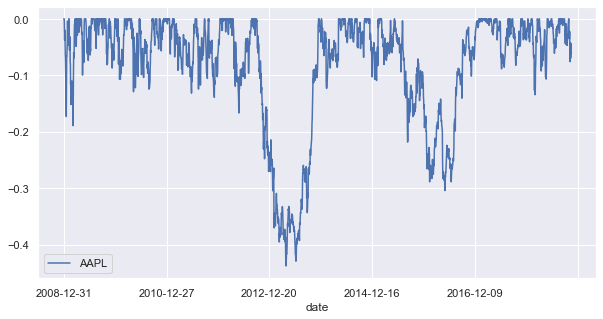

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
daily_drawdown.plot(ax=ax);
plt.legend(loc="best");
plt.show()

In [13]:
# Using the average daily return to calculate portfolio return

returns = prices_train_df.pct_change() # get the assets daily returns
mean_daily_returns = returns.mean().values

uw_returns = np.dot(mean_daily_returns, uniform_weights)

print("uniform weights portfolio average daily return = {:.4%}".format(uw_returns))

uniform weights portfolio average daily return = 0.0713%


In [14]:
#Annualized Return, Variance and Standard Deviation

def get_annualized_return(prices, weigths):
    months = (pd.to_datetime(prices_train_df.index)[-1] - pd.to_datetime(prices_train_df.index)[0]) / np.timedelta64(1, 'M')
    months = np.floor(months)
    total_return = (prices.iloc[-1].dot(weigths) - prices.iloc[0].dot(weigths)) / prices.iloc[0].dot(weigths)
    annualized_return = ((1 + total_return) ** (12 / months)) - 1
    return annualized_return


uw_annual_return = get_annualized_return(prices_train_df, uniform_weights)

def get_portfolio_variance(returns, weigths):
    covariance_returns = returns.cov() * 250
    return np.dot(weigths.T, np.dot(covariance_returns, weigths))

uw_var = get_portfolio_variance(returns, uniform_weights)

print("uniform weights portfolio annualized return = {:.4%}".format(uw_annual_return))
print("uniform weights portfolio annualized variance = {:.1%}".format(uw_var))
print("uniform weights portfolio annualized std = {:.1%}".format(np.sqrt(uw_var)))

uniform weights portfolio annualized return = 15.7010%
uniform weights portfolio annualized variance = 2.5%
uniform weights portfolio annualized std = 15.7%


In [15]:
# Sharpe ratio

uniform_returns = returns.dot(uniform_weights)

rfr = 0.04 #Risk free rate

uw_vol = uniform_returns.std() * np.sqrt(250)

uw_sharpe_ratio = ((uw_annual_return  - rfr) / uw_vol)

print("uniform weights portfolio sharpe ratio = {:.2f}".format(uw_sharpe_ratio))

uniform weights portfolio sharpe ratio = 0.74


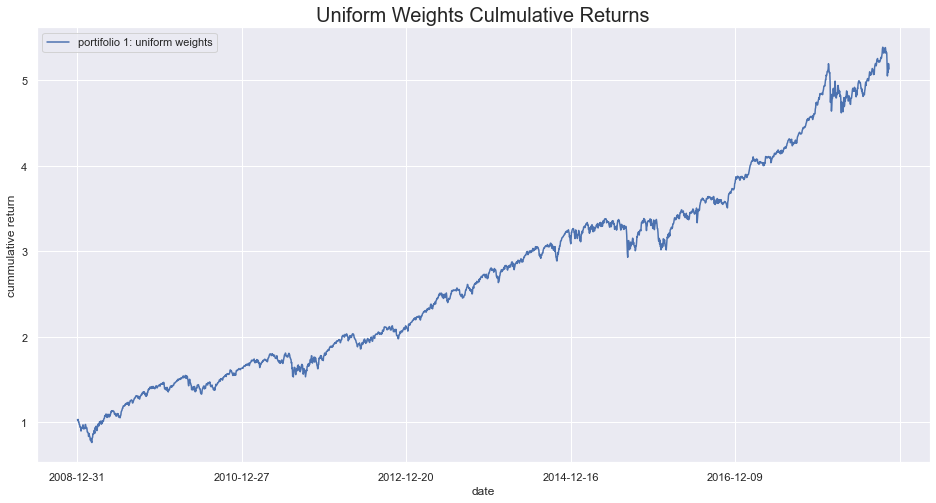

In [24]:
# Plotting the cummulative return
uniform_cum_returns = (1 + uniform_returns).cumprod()
uniform_cum_returns.name = "portifolio 1: uniform weights"

fig, ax = plt.subplots(figsize=(16,8))
uniform_cum_returns.plot(ax=ax);

plt.legend(loc="best");
ax.set_ylabel("cummulative return");
ax.set_title('Uniform Weights Culmulative Returns', fontsize=20)

fig.savefig('results/uniform_weights_portfolio.png');

### 4.4 Maximum Sharpe Portfolio
---
We use PyPortfolioOpt library to get the weights for the Maximum Sharpe Portfolio

In [25]:
mu = expected_returns.mean_historical_return(prices_train_df)
Sigma = risk_models.sample_cov(prices_train_df)
ef = EfficientFrontier(mu,Sigma)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
max_sharpe_portfolio = pd.DataFrame(cleaned_weights, index=[0])

print("max sharpe portfolio:")
show_clean_p(max_sharpe_portfolio)

_ = ef.portfolio_performance(verbose=True, risk_free_rate=rfr)

print()

max sharpe portfolio:


,AAPL,MSFT,JPM,V,RTX,PG,GS,NKE,DIS,AXP,HD,INTC,WMT,IBM,MRK,UNH,KO,CAT,TRV,JNJ,CVX,MCD,VZ,CSCO,XOM,BA,MMM,PFE,WBA,DD
0,35.704%,0.000%,0.000%,14.646%,0.000%,0.000%,0.000%,3.992%,0.000%,0.000%,21.494%,0.000%,0.000%,0.000%,0.000%,17.741%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,6.423%,0.000%,0.000%,0.000%,0.000%


Expected annual return: 30.4%
Annual volatility: 18.3%
Sharpe Ratio: 1.45



### 4.5 Store the Data Frames

In [26]:
%store max_sharpe_portfolio
%store uniform_weights_port

%store prices_train_df
%store prices_test_df

Stored 'max_sharpe_portfolio' (DataFrame)
Stored 'uniform_weights_port' (DataFrame)
Stored 'prices_train_df' (DataFrame)
Stored 'prices_test_df' (DataFrame)
